In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

/home/ubuntu/.local/share/virtualenvs/kaggle-salt-WGcE8zWi/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/.local/share/virtualenvs/kaggle-salt-WGcE8zWi/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6583402901345489121, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 185991168
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17620668645565483426
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"]

In [3]:
from utils import *

import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

In [4]:
ids_train = load_array("data/array/ids_train")
X_train = load_array("data/array/X_train")
y_train = load_array("data/array/y_train").astype(np.bool)
# ids_test = load_array("data/test_ids")
# X_test = load_array("data/x_test")

In [5]:
im_width = X_train.shape[1]
im_height = X_train.shape[2]
im_chan = X_train.shape[3]

In [6]:
X_train.shape, y_train.shape, im_width, im_height, im_chan

((4000, 128, 128, 1), (4000, 128, 128, 1), 128, 128, 1)

## Model

Now we define the actual Unet model

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [8]:
inputs = Input((im_height, im_width, im_chan))
s = Lambda(lambda x: x / 255) (inputs)

In [9]:
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

In [10]:
outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

In [11]:
model = Model(inputs=[inputs], outputs=[outputs])

In [12]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])

In [13]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 8)  80          lambda[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  584         conv2d[0][0]                     
__________________________________________________________________________________________________
max_poolin

In [14]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('models/unet-simple.model', verbose=1, save_best_only=True)
results = model.fit(X_train, y_train, validation_split=0.1, batch_size=8, epochs=30, callbacks=[earlystopper, checkpointer])

Train on 3600 samples, validate on 400 samples
Epoch 1/30
3600/3600 [==============================] - 23s 6ms/step - loss: 0.5635 - mean_iou: 0.3767 - val_loss: 0.5078 - val_mean_iou: 0.3774

Epoch 00001: val_loss improved from inf to 0.50785, saving model to models/unet-simple.model
Epoch 2/30
3600/3600 [==============================] - 20s 5ms/step - loss: 0.5416 - mean_iou: 0.3777 - val_loss: 0.5167 - val_mean_iou: 0.3780

Epoch 00002: val_loss did not improve from 0.50785
Epoch 3/30
3600/3600 [==============================] - 20s 5ms/step - loss: 0.4526 - mean_iou: 0.3778 - val_loss: 0.3670 - val_mean_iou: 0.3799

Epoch 00003: val_loss improved from 0.50785 to 0.36697, saving model to models/unet-simple.model
Epoch 4/30
3600/3600 [==============================] - 20s 5ms/step - loss: 0.3884 - mean_iou: 0.4017 - val_loss: 0.3291 - val_mean_iou: 0.4213

Epoch 00004: val_loss improved from 0.36697 to 0.32910, saving model to models/unet-simple.model
Epoch 5/30
3600/3600 [=========

## Check the predictions

Let's check one prediction

In [15]:
pred_train = model.predict(X_train, verbose=1)

4000/4000 [==============================] - 4s 956us/step


In [16]:
pred_train.shape

(4000, 128, 128, 1)

In [17]:
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image as image_utils

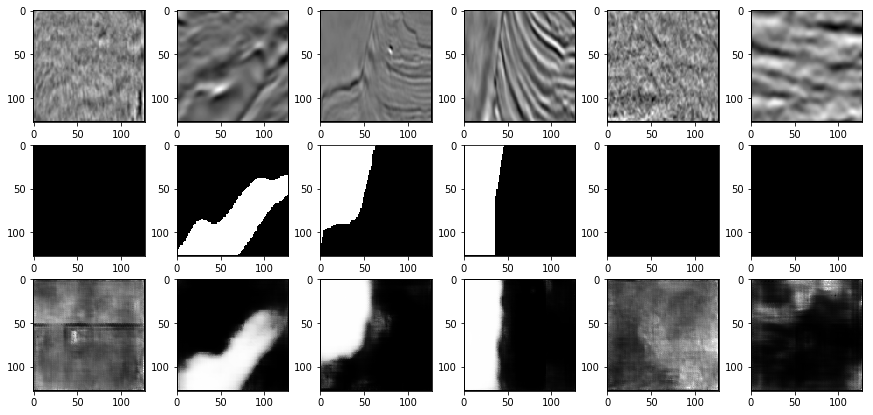

In [19]:
n_images = 6
fig, axarr = plt.subplots(3, n_images, figsize=(15, 7))
for image in range(n_images):
    n = random.randint(1, pred_train.shape[0])
    axarr[0, image].imshow(image_utils.array_to_img(X_train[n]))
    axarr[1, image].imshow(image_utils.array_to_img(y_train[n]))
    axarr[2, image].imshow(image_utils.array_to_img(pred_train[n]))